## Upload data

In [14]:
import sagemaker
from sagemaker import get_execution_role
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

sagemaker_session = sagemaker.Session()

role = get_execution_role()

In [4]:
data_dir = "/home/ec2-user/SageMaker/efs/data"
data_bucket = sagemaker_session.upload_data(path=os.path.join(data_dir,'brain-segmentation'), key_prefix='brain-segmentation')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208


In [5]:
sample_train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "sample-train"), distribution='FullyReplicated')
sample_validation_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "sample-validation"), distribution='FullyReplicated')
train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "train"), distribution='FullyReplicated')
validation_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "validation"), distribution='FullyReplicated')
distributed_train_s3 = sagemaker.s3_input(s3_data=os.path.join(data_bucket, "distributed-training"), distribution='ShardedByS3Key')

## Test Input

In [169]:
test_brain = np.array(Image.open("test.png"))[np.newaxis,np.newaxis,:]

In [170]:
test_brain.shape

(1, 1, 176, 208)

## Local Mode

In [ ]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/mxnet_gluon_mnist/setup.sh

In [ ]:
!/bin/bash ./setup.sh

In [172]:
local_unet_job = 'DEMO-local-unet-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [173]:
from sagemaker.mxnet import MXNet

local_estimator = MXNet(entry_point='brain_segmentation.py',
                            base_job_name = local_unet_job,
                            source_dir = 'source_dir',
                            role=role,
                            train_instance_count=1, 
                            train_instance_type='local',
                            hyperparameters={
                                'learning_rate': 1E-3 * 16,
                                'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                'network':'unet',
                                'batch_size': 8,
                                'epochs':1
                        })

In [174]:
local_estimator.fit({'train':sample_train_s3, 'test':sample_validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-local-unet-job-2018-06-07-18-34-57-2018-06-07-18-34-59-657


Attaching to tmpno6lol_algo-1-61VPN_1
algo-1-61VPN_1  | 2018-06-07 18:35:01,943 INFO - root - running container entrypoint
algo-1-61VPN_1  | 2018-06-07 18:35:01,944 INFO - root - starting train task
algo-1-61VPN_1  | 2018-06-07 18:35:01,951 INFO - container_support.training - Training starting
algo-1-61VPN_1  | 2018-06-07 18:35:02,505 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'test': {u'ContentType': u'application/octet-stream'}, u'train': {u'ContentType': u'application/octet-stream'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1-61VPN', u'hosts': [u'algo-1-61VPN']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'h

In [11]:
local_unet_endpoint = 'DEMO-local-unet-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [12]:
local_predictor = local_estimator.deploy(initial_instance_count=1, instance_type='local',
                                         endpoint_name=local_unet_endpoint)

INFO:sagemaker:Creating model with name: DEMO-local-unet-job-2018-06-03-17-43-08-2018-06-03-17-43-11-758
INFO:sagemaker:Creating endpoint with name DEMO-local-unet-endpoint-2018-06-03-17-43-58


!

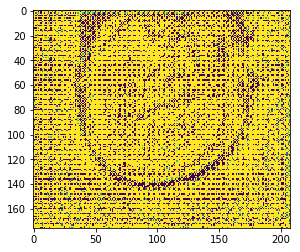

In [15]:
response = local_predictor.predict(test_brain.tolist())
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.imshow(output)

## UNet - 1 Machine

In [26]:
unet_single_machine_job = 'DEMO-unet-single-machine-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [27]:
unet_single_machine_estimator = MXNet(entry_point='brain_segmentation.py',
                                                base_job_name = unet_single_machine_job,
                                                source_dir = 'source_dir',
                                                role=role,
                                                train_instance_count=1, 
                                                train_instance_type='ml.p3.2xlarge',
                                                hyperparameters={
                                                    'learning_rate': 1E-3,
                                                    'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                                    'network':'unet',
                                                    'batch_size': 32,
                                            })

In [28]:
unet_single_machine_estimator.fit({'train':train_s3, 'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-unet-single-machine-job-2018-06-03-2018-06-03-18-41-28-413


.......................
2018-06-03 18:45:03,589 INFO - root - running container entrypoint
2018-06-03 18:45:03,589 INFO - root - starting train task
2018-06-03 18:45:03,609 INFO - container_support.training - Training starting
2018-06-03 18:45:05,938 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'outp

2018-06-03 18:51:27,272 INFO - root - Epoch[19] Train-avg_dice_coef_metric=0.260618
2018-06-03 18:51:27,272 INFO - root - Epoch[19] Time cost=16.356
2018-06-03 18:51:29,776 INFO - root - Epoch[19] Validation-avg_dice_coef_metric=0.282494
2018-06-03 18:51:45,849 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.251234
2018-06-03 18:51:45,849 INFO - root - Epoch[20] Time cost=16.073
2018-06-03 18:51:48,304 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.271702
2018-06-03 18:52:04,345 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.253188
2018-06-03 18:52:04,345 INFO - root - Epoch[21] Time cost=16.041
2018-06-03 18:52:06,848 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.254631
2018-06-03 18:52:22,972 INFO - root - Epoch[22] Train-avg_dice_coef_metric=0.238767
2018-06-03 18:52:22,973 INFO - root - Epoch[22] Time cost=16.124
2018-06-03 18:52:25,604 INFO - root - Epoch[22] Validation-avg_dice_coef_metric=0.250068
2018-06-03 18:52:41,981 INFO - root - Epoch[23] 

2018-06-03 19:01:07,745 INFO - root - Epoch[50] Train-avg_dice_coef_metric=0.175469
2018-06-03 19:01:07,746 INFO - root - Epoch[50] Time cost=16.037
2018-06-03 19:01:10,284 INFO - root - Epoch[50] Validation-avg_dice_coef_metric=0.239478
2018-06-03 19:01:26,505 INFO - root - Epoch[51] Train-avg_dice_coef_metric=0.171581
2018-06-03 19:01:26,505 INFO - root - Epoch[51] Time cost=16.221
2018-06-03 19:01:28,969 INFO - root - Epoch[51] Validation-avg_dice_coef_metric=0.207068
2018-06-03 19:01:45,307 INFO - root - Epoch[52] Train-avg_dice_coef_metric=0.176434
2018-06-03 19:01:45,308 INFO - root - Epoch[52] Time cost=16.339
2018-06-03 19:01:47,857 INFO - root - Epoch[52] Validation-avg_dice_coef_metric=0.206507
2018-06-03 19:02:03,883 INFO - root - Epoch[53] Train-avg_dice_coef_metric=0.165569
2018-06-03 19:02:03,883 INFO - root - Epoch[53] Time cost=16.026
2018-06-03 19:02:06,411 INFO - root - Epoch[53] Validation-avg_dice_coef_metric=0.197832
2018-06-03 19:02:22,422 INFO - root - Epoch[54] 

2018-06-03 19:10:48,272 INFO - root - Epoch[81] Train-avg_dice_coef_metric=0.144520
2018-06-03 19:10:48,272 INFO - root - Epoch[81] Time cost=16.087
2018-06-03 19:10:50,819 INFO - root - Epoch[81] Validation-avg_dice_coef_metric=0.230420
2018-06-03 19:11:06,856 INFO - root - Epoch[82] Train-avg_dice_coef_metric=0.134265
2018-06-03 19:11:06,856 INFO - root - Epoch[82] Time cost=16.037
2018-06-03 19:11:09,345 INFO - root - Epoch[82] Validation-avg_dice_coef_metric=0.213241
2018-06-03 19:11:25,595 INFO - root - Epoch[83] Train-avg_dice_coef_metric=0.141653
2018-06-03 19:11:25,596 INFO - root - Epoch[83] Time cost=16.250
2018-06-03 19:11:28,143 INFO - root - Epoch[83] Validation-avg_dice_coef_metric=0.227950
2018-06-03 19:11:44,322 INFO - root - Epoch[84] Train-avg_dice_coef_metric=0.144171
2018-06-03 19:11:44,322 INFO - root - Epoch[84] Time cost=16.179
2018-06-03 19:11:46,906 INFO - root - Epoch[84] Validation-avg_dice_coef_metric=0.225800
2018-06-03 19:12:03,051 INFO - root - Epoch[85] 

## UNET - Distributed (SYNCHRONOUS)

In [19]:
unet_distributed_job = 'DEMO-unet-distributed-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [20]:
unet_distributed_estimator = MXNet(entry_point='brain_segmentation.py',
                                   base_job_name = unet_distributed_job,
                                    source_dir = 'source_dir',
                                    role=role,
                                    train_instance_count=2, 
                                    train_instance_type='ml.p3.2xlarge',
                                    hyperparameters={
                                        'epochs': 50,
                                        'learning_rate': 1E-3,
                                        'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                        'network':'unet',
                                        'batch_size': 32,
                        })

In [21]:
unet_distributed_estimator.fit({'train':distributed_train_s3,
                            'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-unet-distributed-job-2018-06-03-18-2018-06-03-18-05-57-843


.........................
2018-06-03 18:09:56,888 INFO - root - running container entrypoint
2018-06-03 18:09:56,889 INFO - root - starting train task
2018-06-03 18:09:56,909 INFO - container_support.training - Training starting
2018-06-03 18:09:59,179 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'ShardedByS3Key'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-2', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1', u'algo-2']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': u'/opt/ml/output/

2018-06-03 18:11:02,227 INFO - root - Epoch[4] Train-avg_dice_coef_metric=0.348321
2018-06-03 18:11:02,227 INFO - root - Epoch[4] Time cost=8.300
2018-06-03 18:11:02,045 INFO - root - Epoch[4] Train-avg_dice_coef_metric=0.349021
2018-06-03 18:11:02,045 INFO - root - Epoch[4] Time cost=8.331
2018-06-03 18:11:04,495 INFO - root - Epoch[4] Validation-avg_dice_coef_metric=0.343391
2018-06-03 18:11:04,664 INFO - root - Epoch[4] Validation-avg_dice_coef_metric=0.362441
2018-06-03 18:11:12,841 INFO - root - Epoch[5] Train-avg_dice_coef_metric=0.342326
2018-06-03 18:11:12,841 INFO - root - Epoch[5] Time cost=8.177
2018-06-03 18:11:12,870 INFO - root - Epoch[5] Train-avg_dice_coef_metric=0.340643
2018-06-03 18:11:12,871 INFO - root - Epoch[5] Time cost=8.375
2018-06-03 18:11:15,405 INFO - root - Epoch[5] Validation-avg_dice_coef_metric=0.348739
2018-06-03 18:11:15,406 INFO - root - Epoch[5] Validation-avg_dice_coef_metric=0.332649
2018-06-03 18:11:23,835 INFO - root - Epoch[6] Train-avg_dice_co

2018-06-03 18:13:55,841 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.303067
2018-06-03 18:13:55,841 INFO - root - Epoch[20] Time cost=8.478
2018-06-03 18:13:55,884 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.299484
2018-06-03 18:13:55,884 INFO - root - Epoch[20] Time cost=8.316
2018-06-03 18:13:58,383 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.320477
2018-06-03 18:13:58,350 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.305211
2018-06-03 18:14:06,577 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.299738
2018-06-03 18:14:06,578 INFO - root - Epoch[21] Time cost=8.194
2018-06-03 18:14:06,508 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.299941
2018-06-03 18:14:06,508 INFO - root - Epoch[21] Time cost=8.158
2018-06-03 18:14:08,994 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.310469
2018-06-03 18:14:09,093 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.320817
2018-06-03 18:14:17,502 INFO - root - Epoch[22] Trai

2018-06-03 18:16:49,257 INFO - root - Epoch[36] Train-avg_dice_coef_metric=0.251868
2018-06-03 18:16:49,257 INFO - root - Epoch[36] Time cost=8.349
2018-06-03 18:16:50,482 INFO - root - Epoch[36] Train-avg_dice_coef_metric=0.262335
2018-06-03 18:16:50,483 INFO - root - Epoch[36] Time cost=8.487
2018-06-03 18:16:51,822 INFO - root - Epoch[36] Validation-avg_dice_coef_metric=0.245293
2018-06-03 18:16:52,985 INFO - root - Epoch[36] Validation-avg_dice_coef_metric=0.278764
2018-06-03 18:17:00,245 INFO - root - Epoch[37] Train-avg_dice_coef_metric=0.243355
2018-06-03 18:17:00,246 INFO - root - Epoch[37] Time cost=8.424
2018-06-03 18:17:02,834 INFO - root - Epoch[37] Validation-avg_dice_coef_metric=0.268945
2018-06-03 18:17:01,234 INFO - root - Epoch[37] Train-avg_dice_coef_metric=0.261679
2018-06-03 18:17:01,234 INFO - root - Epoch[37] Time cost=8.249
2018-06-03 18:17:03,792 INFO - root - Epoch[37] Validation-avg_dice_coef_metric=0.293890
2018-06-03 18:17:11,663 INFO - root - Epoch[38] Trai

## Inference Endpoints

### Default Endpoint

In [22]:
unet_endpoint = 'DEMO-unet-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [23]:
unet_predictor = unet_single_machine_estimator.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                                                     endpoint_name=unet_endpoint)

INFO:sagemaker:Creating model with name: DEMO-unet-single-machine-job-2018-06-03-2018-06-03-17-45-33-465
INFO:sagemaker:Creating endpoint with name DEMO-unet-endpoint-2018-06-03-18-36-33


--------------------------------------------------!

In [24]:
response = unet_predictor.predict(test_brain.tolist())

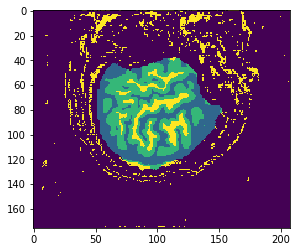

In [25]:
output = np.argmax(np.array(response), axis=(1))[0].astype(np.uint8)
plt.imshow(output)

### S3 Endpoint

In [493]:
unet_s3_endpoint = 'DEMO-unet-s3-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [494]:
unet_single_machine_estimator.entry_point = "brain_segmentation_s3_transform.py"

In [495]:
unet_s3_predictor = unet_single_machine_estimator.deploy(instance_type='ml.c5.xlarge', initial_instance_count=1,
                                                     endpoint_name=unet_s3_endpoint)

INFO:sagemaker:Creating model with name: DEMO-unet-single-machine-job-2018-05-31-2018-05-31-20-08-46-514
INFO:sagemaker:Creating endpoint with name DEMO-unet-s3-endpoint-2018-06-02-03-58-46


---------------------------------------------------------------!

In [497]:
response = unet_s3_predictor.predict([request_body])

In [498]:
s3.download_file(Bucket=response['bucket'], Key=response['prefix'], Filename = "result.png")

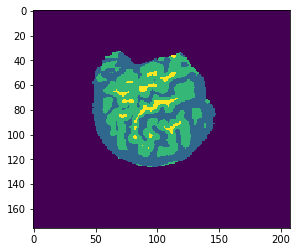

In [500]:
plt.imshow(np.array(Image.open("result.png")))

## ENet - 1 Machine

In [77]:
enet_single_machine_job = 'DEMO-enet-single-machine-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [78]:
enet_single_machine_estimator = MXNet(entry_point='brain_segmentation.py',
                                                base_job_name = enet_single_machine_job,
                                                source_dir = 'source_dir',
                                                role=role,
                                                train_instance_count=1, 
                                                train_instance_type='ml.p3.2xlarge',
                                                hyperparameters={
                                                    'learning_rate': 1E-3,
                                                    'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                                    'network':'enet',
                                                    'batch_size': 32,
                                            })

In [79]:
enet_single_machine_estimator.fit({'train':train_s3, 'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-enet-single-machine-job-2018-06-04-2018-06-04-02-14-19-681


.......................
2018-06-04 02:18:00,188 INFO - root - running container entrypoint
2018-06-04 02:18:00,188 INFO - root - starting train task
2018-06-04 02:18:00,208 INFO - container_support.training - Training starting
2018-06-04 02:18:02,457 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'outp

2018-06-04 02:21:56,563 INFO - root - Epoch[19] Train-avg_dice_coef_metric=0.328765
2018-06-04 02:21:56,563 INFO - root - Epoch[19] Time cost=9.513
2018-06-04 02:21:58,459 INFO - root - Epoch[19] Validation-avg_dice_coef_metric=0.334525
2018-06-04 02:22:07,848 INFO - root - Epoch[20] Train-avg_dice_coef_metric=0.326914
2018-06-04 02:22:07,848 INFO - root - Epoch[20] Time cost=9.389
2018-06-04 02:22:09,767 INFO - root - Epoch[20] Validation-avg_dice_coef_metric=0.328078
2018-06-04 02:22:19,182 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.327105
2018-06-04 02:22:19,183 INFO - root - Epoch[21] Time cost=9.415
2018-06-04 02:22:21,042 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.336212
2018-06-04 02:22:30,577 INFO - root - Epoch[22] Train-avg_dice_coef_metric=0.327182
2018-06-04 02:22:30,577 INFO - root - Epoch[22] Time cost=9.536
2018-06-04 02:22:32,391 INFO - root - Epoch[22] Validation-avg_dice_coef_metric=0.322249
2018-06-04 02:22:41,954 INFO - root - Epoch[23] Trai

2018-06-04 02:28:02,126 INFO - root - Epoch[51] Train-avg_dice_coef_metric=0.300764
2018-06-04 02:28:02,126 INFO - root - Epoch[51] Time cost=9.590
2018-06-04 02:28:04,037 INFO - root - Epoch[51] Validation-avg_dice_coef_metric=0.299293
2018-06-04 02:28:13,548 INFO - root - Epoch[52] Train-avg_dice_coef_metric=0.300621
2018-06-04 02:28:13,549 INFO - root - Epoch[52] Time cost=9.511
2018-06-04 02:28:15,492 INFO - root - Epoch[52] Validation-avg_dice_coef_metric=0.308881
2018-06-04 02:28:25,027 INFO - root - Epoch[53] Train-avg_dice_coef_metric=0.299184
2018-06-04 02:28:25,027 INFO - root - Epoch[53] Time cost=9.534
2018-06-04 02:28:26,934 INFO - root - Epoch[53] Validation-avg_dice_coef_metric=0.312393
2018-06-04 02:28:36,406 INFO - root - Epoch[54] Train-avg_dice_coef_metric=0.298235
2018-06-04 02:28:36,406 INFO - root - Epoch[54] Time cost=9.472
2018-06-04 02:28:38,312 INFO - root - Epoch[54] Validation-avg_dice_coef_metric=0.305125
2018-06-04 02:28:47,918 INFO - root - Epoch[55] Trai

2018-06-04 02:34:10,152 INFO - root - Epoch[83] Train-avg_dice_coef_metric=0.279659
2018-06-04 02:34:10,152 INFO - root - Epoch[83] Time cost=9.734
2018-06-04 02:34:12,179 INFO - root - Epoch[83] Validation-avg_dice_coef_metric=0.302183
2018-06-04 02:34:21,744 INFO - root - Epoch[84] Train-avg_dice_coef_metric=0.277926
2018-06-04 02:34:21,745 INFO - root - Epoch[84] Time cost=9.565
2018-06-04 02:34:23,781 INFO - root - Epoch[84] Validation-avg_dice_coef_metric=0.273269
2018-06-04 02:34:33,465 INFO - root - Epoch[85] Train-avg_dice_coef_metric=0.277165
2018-06-04 02:34:33,466 INFO - root - Epoch[85] Time cost=9.684
2018-06-04 02:34:35,380 INFO - root - Epoch[85] Validation-avg_dice_coef_metric=0.275591
2018-06-04 02:34:45,115 INFO - root - Epoch[86] Train-avg_dice_coef_metric=0.276763
2018-06-04 02:34:45,116 INFO - root - Epoch[86] Time cost=9.735
2018-06-04 02:34:47,070 INFO - root - Epoch[86] Validation-avg_dice_coef_metric=0.282257
2018-06-04 02:34:56,670 INFO - root - Epoch[87] Trai

## mxnet 0.11

In [147]:
enet_eleven_job = 'DEMO-enet-eleven-job-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [148]:
enet_eleven_estimator = MXNet(entry_point='brain_segmentation.py',
                                                base_job_name = enet_eleven_job,
                                                source_dir = 'source_dir',
                                                role=role,
                                                train_instance_count=1, 
                                                train_instance_type='ml.p3.2xlarge',
                                                hyperparameters={
                                                    'learning_rate': 1E-3,
                                                    'class_weights': [[ 1.35, 17.18,  8.29, 12.42]],
                                                    'network':'enet',
                                                    'batch_size': 32,
                                            })

In [149]:
region = sagemaker_session.boto_session.region_name
enet_eleven_estimator.train_image = lambda:'780728360657.dkr.ecr.{}.amazonaws.com/sagemaker-mxnet-py2-gpu:1.0'.format(region)

In [150]:
enet_eleven_estimator.fit({'train':train_s3, 'test':validation_s3})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208
INFO:sagemaker:Creating training-job with name: DEMO-enet-eleven-job-2018-06-04-04-49-0-2018-06-04-04-49-07-097


.......................
executing startup script (first run)
2018-06-04 04:52:51,585 INFO - root - running container entrypoint
2018-06-04 04:52:51,585 INFO - root - starting train task
2018-06-04 04:52:52,675 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'network_interface_name': u'ethwe', u'hosts': [u'algo-1']}, 'user_script_name': u'brain_segmentation.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '

2018-06-04 04:57:10,913 INFO - root - Epoch[21] Train-avg_dice_coef_metric=0.304270
2018-06-04 04:57:10,913 INFO - root - Epoch[21] Time cost=8.789
2018-06-04 04:57:13,229 INFO - root - Epoch[21] Validation-avg_dice_coef_metric=0.310643
2018-06-04 04:57:22,073 INFO - root - Epoch[22] Train-avg_dice_coef_metric=0.299768
2018-06-04 04:57:22,073 INFO - root - Epoch[22] Time cost=8.844
2018-06-04 04:57:24,374 INFO - root - Epoch[22] Validation-avg_dice_coef_metric=0.305673
2018-06-04 04:57:33,400 INFO - root - Epoch[23] Train-avg_dice_coef_metric=0.298148
2018-06-04 04:57:33,401 INFO - root - Epoch[23] Time cost=9.027
2018-06-04 04:57:35,684 INFO - root - Epoch[23] Validation-avg_dice_coef_metric=0.298992
2018-06-04 04:57:44,567 INFO - root - Epoch[24] Train-avg_dice_coef_metric=0.295296
2018-06-04 04:57:44,567 INFO - root - Epoch[24] Time cost=8.883
2018-06-04 04:57:46,862 INFO - root - Epoch[24] Validation-avg_dice_coef_metric=0.312386
2018-06-04 04:57:55,638 INFO - root - Epoch[25] Trai

2018-06-04 05:03:12,053 INFO - root - Epoch[53] Train-avg_dice_coef_metric=0.244655
2018-06-04 05:03:12,053 INFO - root - Epoch[53] Time cost=8.995
2018-06-04 05:03:14,326 INFO - root - Epoch[53] Validation-avg_dice_coef_metric=0.290085
2018-06-04 05:03:23,379 INFO - root - Epoch[54] Train-avg_dice_coef_metric=0.244724
2018-06-04 05:03:23,380 INFO - root - Epoch[54] Time cost=9.053
2018-06-04 05:03:25,666 INFO - root - Epoch[54] Validation-avg_dice_coef_metric=0.249492
2018-06-04 05:03:34,700 INFO - root - Epoch[55] Train-avg_dice_coef_metric=0.250986
2018-06-04 05:03:34,700 INFO - root - Epoch[55] Time cost=9.034
2018-06-04 05:03:36,989 INFO - root - Epoch[55] Validation-avg_dice_coef_metric=0.266141
2018-06-04 05:03:45,843 INFO - root - Epoch[56] Train-avg_dice_coef_metric=0.244764
2018-06-04 05:03:45,843 INFO - root - Epoch[56] Time cost=8.854
2018-06-04 05:03:48,126 INFO - root - Epoch[56] Validation-avg_dice_coef_metric=0.270541
2018-06-04 05:03:56,985 INFO - root - Epoch[57] Trai

2018-06-04 05:09:12,550 INFO - root - Epoch[85] Train-avg_dice_coef_metric=0.218253
2018-06-04 05:09:12,550 INFO - root - Epoch[85] Time cost=9.048
2018-06-04 05:09:14,865 INFO - root - Epoch[85] Validation-avg_dice_coef_metric=0.233243
2018-06-04 05:09:23,809 INFO - root - Epoch[86] Train-avg_dice_coef_metric=0.216462
2018-06-04 05:09:23,810 INFO - root - Epoch[86] Time cost=8.945
2018-06-04 05:09:26,107 INFO - root - Epoch[86] Validation-avg_dice_coef_metric=0.227813
2018-06-04 05:09:35,035 INFO - root - Epoch[87] Train-avg_dice_coef_metric=0.211800
2018-06-04 05:09:35,035 INFO - root - Epoch[87] Time cost=8.928
2018-06-04 05:09:37,323 INFO - root - Epoch[87] Validation-avg_dice_coef_metric=0.223888
2018-06-04 05:09:46,275 INFO - root - Epoch[88] Train-avg_dice_coef_metric=0.214226
2018-06-04 05:09:46,275 INFO - root - Epoch[88] Time cost=8.953
2018-06-04 05:09:48,610 INFO - root - Epoch[88] Validation-avg_dice_coef_metric=0.244663
2018-06-04 05:09:57,613 INFO - root - Epoch[89] Trai

In [151]:
enet_eleven_estimator.model_data

u's3://sagemaker-us-east-1-288000045208/DEMO-enet-eleven-job-2018-06-04-04-49-0-2018-06-04-04-49-07-097/output/model.tar.gz'

## Greengrass

* Follow instructions to set up ggc on rpi. 
* Then follow ML instructions, put MXNet in device.
* Replace with your own model path from above
* Replace zip package with one I will provide HERE
* Continue instructions
* Choose "Sagemaker model" instead doing ML resource selection
* Continue steps to Deploy
* add boot commands